# Create combined footprint and soil class data

The netCDF dataset created here consists of footprint values (% m<sup>-2</sup>) multiplied by area of different soil classes in each 30 minute timestep.

The soil classes are in this order in the netCDF dataset
- Fallen tree
- Dry branch
- Exposed peat
- Light moss
- Dark moss
- Green vegetation
- Ditch
- Tree
- Covered ditch
- Instruments

Edited <br />
22.2.2024: New footprint files from Olli <br />
29.4.2024: New footprint files from Olli

In [7]:
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import xarray as xr

from shapely.geometry import Point, Polygon
from dotenv import load_dotenv; load_dotenv()

sns.set_context('notebook', font_scale=1.5)

## Load soil class data

In [8]:
SOILCLASSIFICATION_DATA = os.getenv('SOILCLASSIFICATION_DATA')
ONEDRIVE_FOLDER = os.getenv('ONEDRIVE_FOLDER')

In [9]:
data = gpd.read_file(SOILCLASSIFICATION_DATA)

## Load footprint data

In [10]:
import os

In [11]:
os.listdir(f'{ONEDRIVE_FOLDER}footprint/20240220/')

['fpr_contour_80_FI-Ran_20220625_1600.shp',
 'fpr_FI-Ran_2022_10.nc',
 'fpr_FI-Ran_2022_9.nc',
 'fpr_contour_80_FI-Ran_20220625_1400.shp',
 'fpr_FI-Ran_2022_8.nc',
 'fpr_contour_80_FI-Ran_20220625_1500.dbf',
 'fpr_FI-Ran_2022_11.nc',
 'fpr_FI-Ran_2022_7.nc',
 'fpr_contour_80_FI-Ran_20220625_1500.shp',
 'fpr_FI-Ran_2022_3.nc',
 'fpr_FI-Ran_2022_2.nc',
 'fpr_contour_80_FI-Ran_20220625_1400.dbf',
 'fpr_FI-Ran_2021_11.nc',
 'fpr_FI-Ran_2022_6.nc',
 'fpr_contour_80_FI-Ran_20220625_1600.dbf',
 'fpr_FI-Ran_2022_1.nc',
 'fpr_FI-Ran_2022_5.nc',
 'fpr_FI-Ran_2021_12.nc',
 'fpr_contour_80_FI-Ran_20220625_1430.dbf',
 'fpr_FI-Ran_2022_4.nc',
 'fpr_contour_80_FI-Ran_20220615_1400.dbf',
 'fpr_contour_80_FI-Ran_20220625_1530.shp',
 'fpr_contour_80_FI-Ran_20220625_1530.dbf',
 'fpr_contour_80_FI-Ran_20220615_1400.shp',
 'fpr_FI-Ran_2022_12.nc',
 'fpr_contour_80_FI-Ran_20220625_1430.shp']

In [12]:
fpr = xr.open_dataset(f'data/footprint/fpr_FI-Ran_2022_05.nc')

In [13]:
fpr.info()

xarray.Dataset {
dimensions:
	time = 1336 ;
	x = 801 ;
	y = 801 ;

variables:
	float64 time(time) ;
		time:unit = days since 1970-01-01 00:00:00.0 ;
		time:calendar = standard ;
	float64 x1(x, y) ;
	float64 y1(x, y) ;
	float64 fpr(x, y, time) ;
		fpr:unit = m-2 ;
		fpr:long_name = footprint function ;

// global attributes:
}

### Calculate the total length of time dimension in fpr files

In [14]:
# fpr_files = []
# for file in os.listdir("data/footprint/"):
#     if file.endswith(".nc"):
#         fpr_files.append(file)
#         #print(os.path.join("/mydir", file))

In [15]:
fpr_files = []
for file in os.listdir(f'data/footprint'):
    if file.endswith(".nc"):
        fpr_files.append(file)
        #print(os.path.join("/mydir", file))

In [16]:
fpr_files.sort()

In [17]:
#fpr_files = fpr_files[1:]

In [18]:
fpr_files

['fpr_FI-Ran_2022_01.nc',
 'fpr_FI-Ran_2022_02.nc',
 'fpr_FI-Ran_2022_03.nc',
 'fpr_FI-Ran_2022_04.nc',
 'fpr_FI-Ran_2022_05.nc',
 'fpr_FI-Ran_2022_06.nc',
 'fpr_FI-Ran_2022_07.nc',
 'fpr_FI-Ran_2022_08.nc',
 'fpr_FI-Ran_2022_09.nc',
 'fpr_FI-Ran_2022_10.nc',
 'fpr_FI-Ran_2022_11.nc',
 'fpr_FI-Ran_2022_12.nc']

In [19]:
total_timesteps = 0
for file in fpr_files:
    data_fpr = xr.open_dataset(f'data/footprint/{file}')
    total_timesteps = total_timesteps + data_fpr.time.shape[0]

In [20]:
total_timesteps/48

355.3125

## Define EC tower coordinates

In [21]:
ec_coords = Point(406953.64588356-3, 6784393.57747-6)

## Define region of interest near EC tower

The 400 x 400 m grid will cover the whole 'data' geodataframe but it is left here if a smaller area is needed to be created

In [22]:
x = [-200, 200, 200, -200] + ec_coords.x
y = [200, 200, -200, -200] + ec_coords.y

In [23]:
ec_region = Polygon([[xx, yy] for xx,yy in zip(x,y)])

In [24]:
data_near_ec = data.loc[ec_region.contains(data.geometry), :]

## Plot the region of interest

In [25]:
cmap = mpl.colormaps['tab20'].resampled(len(data_near_ec.classInt.unique()))

In [26]:
data_near_ec.classInt.unique()

array([11,  6,  8,  4,  5,  1,  7,  9, 12, 13])

In [27]:
data_near_ec.shape

(838271, 24)

/Users/opa/Ranskalankorpi_CC_EC/.venv/lib/python3.11/site-packages/geopandas/plotting.py:730: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


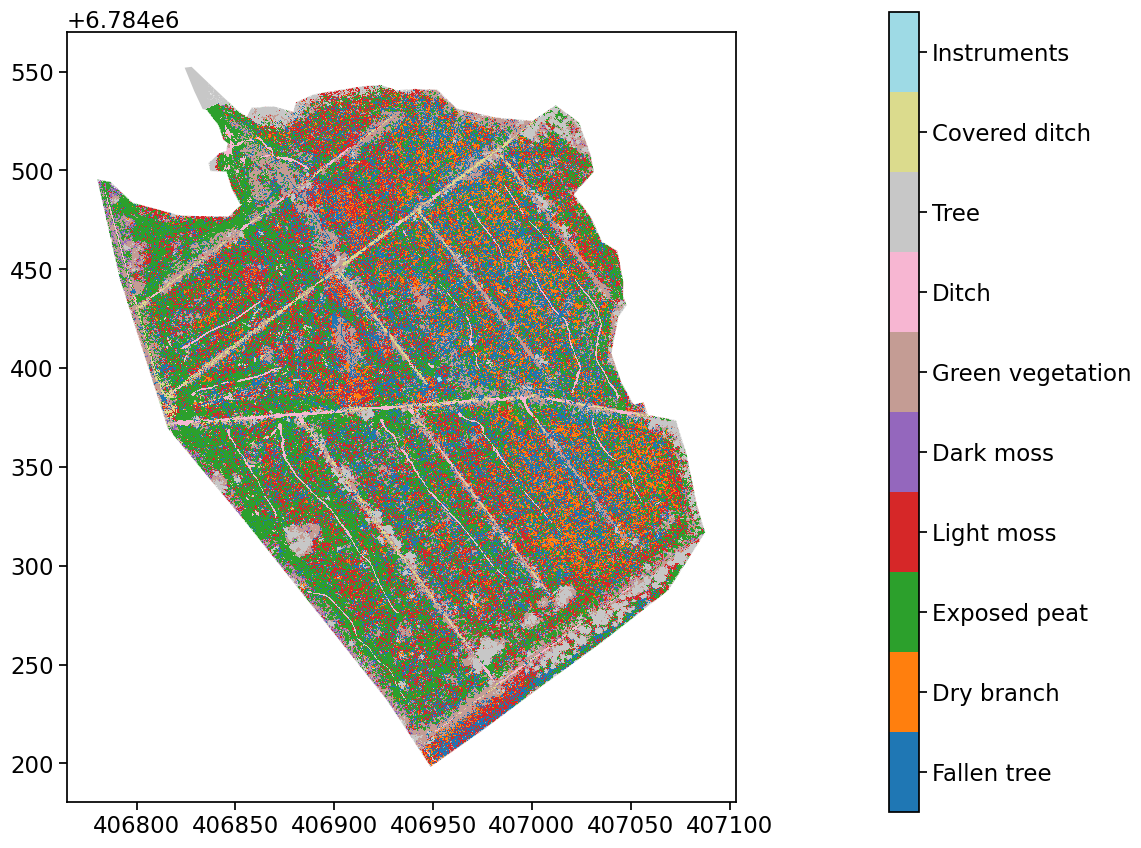

In [28]:

fig, ax = plt.subplots(figsize=(10,10))
vmin = 0
vmax = len(data_near_ec.classInt.unique())
data_near_ec.plot(column='classInt', cmap=cmap, legend=False, ax=ax, categorical=True)

cax = fig.add_axes([1, 0.1, 0.03, 0.8])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)

soil_classes = ['Fallen tree','Dry branch','Exposed peat','Light moss','Dark moss','Green vegetation','Ditch', 'Tree', 'Covered ditch','Instruments']
cbr.set_ticks(np.linspace(0.5,9.5,10))
cbr.set_ticklabels(soil_classes)

## Create polygon grid

In [29]:
data_near_ec.total_bounds

array([ 406780.14315818, 6784198.26317688,  407087.68716611,
       6784552.40989084])

In [30]:
# From: https://spatial-dev.guru/2022/05/22/create-fishnet-grid-using-geopandas-and-shapely/
# Get minX, minY, maxX, maxY
minX, minY, maxX, maxY = data_near_ec.total_bounds

# Correct such that maxX-minX = 400 and maxY-minY = 400 to get the right sized grid

if maxX-minX < 400:
    distance_short = 400 - (maxX-minX)
    distance_per_direction = distance_short / 2
    minX = minX - distance_per_direction
    maxX = maxX + distance_per_direction

if maxY - minY < 400:
    distance_short = 400 - (maxY-minY)
    distance_per_direction = distance_short / 2
    minY = minY - distance_per_direction
    maxY = maxY + distance_per_direction

print(maxX-minX)
print(maxY-minY)

# Create a fishnet
x, y = (minX, minY)
geom_array = []

# Polygon Size
square_size = 0.5
while y <= maxY:
    while x <= maxX:
        geom = Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
        geom_array.append(geom)
        x += square_size
    x = minX
    y += square_size

fpr_grid = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs(data_near_ec.crs)
fpr_grid.insert(0, column='id', value=np.arange(1,fpr_grid.shape[0]+1))

400.0
400.0


In [31]:
data_overlay = gpd.overlay(data_near_ec.loc[:, ['classInt','geometry']],fpr_grid,how='intersection')

In [32]:
data_overlay.head()

,classInt,id,geometry
0,11,569710,"POLYGON ((406833.288 6784531.337, 406833.415 6..."
1,11,569711,"POLYGON ((406833.415 6784531.066, 406833.415 6..."
2,11,569712,"POLYGON ((406833.915 6784530.917, 406833.915 6..."
3,11,569713,"POLYGON ((406834.860 6784530.934, 406834.860 6..."
4,5,569713,"POLYGON ((406834.764 6784530.838, 406834.667 6..."


In [33]:
#fpr.fpr[:,:,27].T.plot()

In [34]:
# fig, ax = plt.subplots(figsize=(8,8))
# vmin = 0
# vmax = len(data_near_ec.classInt.unique())
# data_overlay.plot(column='classInt', cmap=cmap, legend=False, ax=ax, categorical=True)
# ax.contour(fpr.x1+ec_coords.x, fpr.y1+ec_coords.y, fpr.fpr[:, :, 27].T, cmap='gist_gray_r', levels=[0.0001, 0.0005, 0.001, 0.0015, 0.002, 0.0025], linewidths=2)
# cax = fig.add_axes([1, 0.1, 0.03, 0.8])
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm._A = []
# cbr = fig.colorbar(sm, cax=cax,)

# soil_classes = ['Fallen tree','Dry branch','Exposed peat','Light moss','Dark moss','Green vegetation','Ditch', 'Tree', 'Covered ditch','Instruments']
# cbr.set_ticks(np.linspace(0.5,9.5,10))
# cbr.set_ticklabels(soil_classes)

# ax.plot(ec_coords.x, ec_coords.y, 'x', markersize=10, markeredgewidth=4, color='k')


## Create individual geodataframes for different overalay soil classes

In [35]:
classints = np.sort(data_overlay.classInt.unique())

class_datas = []
for i, current_class in enumerate(classints):
    class_datas.append(data_overlay.query(f'classInt=={current_class}'))

## Test calculations for fpr contribution for each land cover class

In [36]:
#fpr_data_current = xr.open_dataset('data/footprint/fpr_FI-Ran_2021_12.nc')
fpr_data_current = xr.open_dataset(f'data/footprint/fpr_FI-Ran_2022_12.nc')

In [37]:
fpr_data = np.array(fpr_data_current.fpr[:, :, 0].fillna(0)).T.flatten()
fpr_grid_current = fpr_grid.assign(fpr=fpr_data)

In [38]:
class_data_areas = [class_datas[k].geometry.area.values for k in range(len(classints))]

In [39]:
# class_percentages_k = np.zeros(classints.shape)
# for k, current_class in enumerate(classints):
#     class_percentages_k[k] = np.sum(class_data_areas[k] * fpr_grid_current.loc[class_data_ids[k], 'fpr'].values)

In [40]:
# class_percentages_k

In [41]:
# class_datas[k].id.values

In [42]:
# class_datas[k].id.values -1

In [43]:
# class_datas[k]

## Run through all fpr files. This takes several hours

In [44]:
class_data_areas = [class_datas[k].geometry.area.values for k in range(len(classints))]

In [45]:
class_data_ids = [class_datas[k].id.values-1 for k in range(len(classints))]

In [46]:
soil_classes = ['Fallen tree','Dry branch','Exposed peat','Light moss','Dark moss','Green vegetation','Ditch', 'Tree', 'Covered ditch','Instruments']
for i, file in enumerate(fpr_files):
    print(file)
    #fpr_data_current = xr.open_dataset(f'data/footprint/{file}')
    fpr_data_current = xr.open_dataset(f'data/footprint/{file}')
    fpr_data_np = np.transpose(fpr_data_current.fpr.to_numpy(), (1, 0 , 2))
    fpr_sum = np.sum(fpr_data_np, axis=(0,1))
    fpr_ind_count = np.where(fpr_sum > 0)[0]
    soilclass_contribution_array = np.zeros((classints.shape[0], fpr_data_current.time.shape[0]))*np.nan
    for j in fpr_ind_count:
        class_percentages = np.zeros(classints.shape)*np.nan
        fpr_data = fpr_data_np[:,:,j].flatten()
        fpr_data[np.isnan(fpr_data)] = 0.0
        for k, current_class in enumerate(classints):
            class_percentages[k] = np.sum(class_data_areas[k] * fpr_data[class_data_ids[k]])

        soilclass_contribution_array[:, j] = class_percentages
        
    monthly_data = xr.Dataset(data_vars={'fpr_contribution': (['soil_class', 'time'], soilclass_contribution_array)},
                                coords={'soil_class': soil_classes, 'time': fpr_data_current.time.values},
                                attrs={'description': 'soil class contribution to footprint'})

    monthly_data.to_netcdf(f'data/footprint/footprint_contribution_{file[-10:-3]}.nc')


fpr_FI-Ran_2022_01.nc
fpr_FI-Ran_2022_02.nc
fpr_FI-Ran_2022_03.nc
fpr_FI-Ran_2022_04.nc
fpr_FI-Ran_2022_05.nc
fpr_FI-Ran_2022_06.nc
fpr_FI-Ran_2022_07.nc
fpr_FI-Ran_2022_08.nc
fpr_FI-Ran_2022_09.nc
fpr_FI-Ran_2022_10.nc
fpr_FI-Ran_2022_11.nc
fpr_FI-Ran_2022_12.nc


## Load all the footprint files and concat together

In [47]:
footprint_files = [f'footprint_contribution_{i[-10:-3]}.nc' for i in fpr_files]

In [48]:
footprint_total_dataset = xr.open_dataset(f'data/footprint/{footprint_files[0]}')
for f in footprint_files[1:]:
    footprint_total_dataset = xr.concat((footprint_total_dataset, xr.open_dataset(f'data/footprint/{f}')), dim='time')


In [49]:
footprint_total_dataset['time'] = pd.to_datetime(footprint_total_dataset.time, unit='D', origin='unix')

In [50]:
footprint_total_dataset.to_netcdf('data/footprint/footprint_soilclass_contribution_2022.nc', format='NETCDF4')

In [51]:
gg = xr.open_dataset('data/footprint/footprint_soilclass_contribution_2022.nc')

In [52]:
gg.info()

xarray.Dataset {
dimensions:
	soil_class = 10 ;
	time = 17055 ;

variables:
	float64 fpr_contribution(soil_class, time) ;
	<U16 soil_class(soil_class) ;
	datetime64[ns] time(time) ;

// global attributes:
	:description = soil class contribution to footprint ;
}

In [53]:
gg.fpr_contribution[:,1092].values

array([2.01798699e-01, 2.22320488e-02, 4.68796212e-01, 1.23683307e-01,
       5.32721454e-03, 5.16631193e-02, 6.37691797e-02, 1.45128376e-02,
       7.83919625e-03, 4.37160306e-13])

In [54]:
pd.to_datetime(gg.time, unit='D', origin='unix')

DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 00:30:00',
               '2022-01-01 01:00:00', '2022-01-01 01:30:00',
               '2022-01-01 02:00:00', '2022-01-01 02:30:00',
               '2022-01-01 03:00:00', '2022-01-01 03:30:00',
               '2022-01-01 04:00:00', '2022-01-01 04:30:00',
               ...
               '2022-12-31 19:00:00', '2022-12-31 19:30:00',
               '2022-12-31 20:00:00', '2022-12-31 20:30:00',
               '2022-12-31 21:00:00', '2022-12-31 21:30:00',
               '2022-12-31 22:00:00', '2022-12-31 22:30:00',
               '2022-12-31 23:00:00', '2022-12-31 23:30:00'],
              dtype='datetime64[ns]', length=17055, freq=None)